In [43]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from osgeo import gdal
import pickle 
import datetime 
import multiprocessing
import cartopy
import xarray as xr
import os
import glob 
import geopandas as gpd
import seaborn as sns
from pyproj import Proj, Transformer

# Load in custom helper functions: 
import sys 
sys.path.append('../scripts/')
from load_data import open_pickle, read_tif, write_geotiff, icemask_from_tif
from helper_tools import number_of_meltdays, melt_season, window_comparison


# Correct Projection for the plots (EPSG: 3413, is specified wrongly in cartopy and is therefore manually defined)
plot_proj = cartopy.crs.Stereographic(central_longitude=-45,central_latitude=90,true_scale_latitude=70)

# For consistant plotting on Greenland
def plot_greenland(data, ax, transform = cartopy.crs.epsg('3413'), mask = None, 
                   vmin = 0, vmax = 100, 
                   cbar = False, cbar_label = None, cmap = 'PuBuGn'): 
    if mask is not None: 
        # Mask data: 
        data = data * mask 
    
    plot = ax.scatter(grid_X, grid_Y, c = np.flip(data, axis =0 ), 
               transform = transform, s = 0.5, cmap = cmap, 
               vmin = vmin, vmax = vmax)
    ax.add_feature(cartopy.feature.LAND,color = 'tan', alpha = 0.7)
    ax.coastlines(resolution='50m', linewidth = 0.1)
    if cbar:
        plt.colorbar(plot , ax = ax , label = cbar_label)
    return plot


# Choose year and import RCMs

In [14]:
year = 2020
home_dir = '/Volumes/disk3s1/enveo/'

# Load in regridded RCMs:
hirham = open_pickle(home_dir + f'/regriddedRCM/HIRHAM_{year}_regridded_nearest.pkl')
racmo = open_pickle(home_dir + f'/regriddedRCM/RACMO_{year}_regridded_nearest.pkl')
mar = open_pickle(home_dir + f'/regriddedRCM/MAR_{year}_regridded_cubic.pkl')
carra = open_pickle(home_dir + f'/regriddedRCM/CARRA_{year}_regridded_nearest.pkl')

# create ensemble mean:
ens = np.stack((hirham,racmo,mar,carra), axis=-1)
ens_mean = np.mean(ens, axis = 3)

# load a random scene and convert it to the an icemask: 
ascat_mask = icemask_from_tif(home_dir + '/ASCAT/2021/meltmap_2021-01-02.tif')

# Load grid (used for plotting); 
grid = xr.open_dataset(home_dir + '/tif_grid.nc')
grid_X, grid_Y = np.meshgrid(grid.x,grid.y)

# Compute onset, end and duration of melt season for RCM

/Users/annpu/miniconda3/envs/4DG_melt/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/annpu/miniconda3/envs/4DG_melt/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


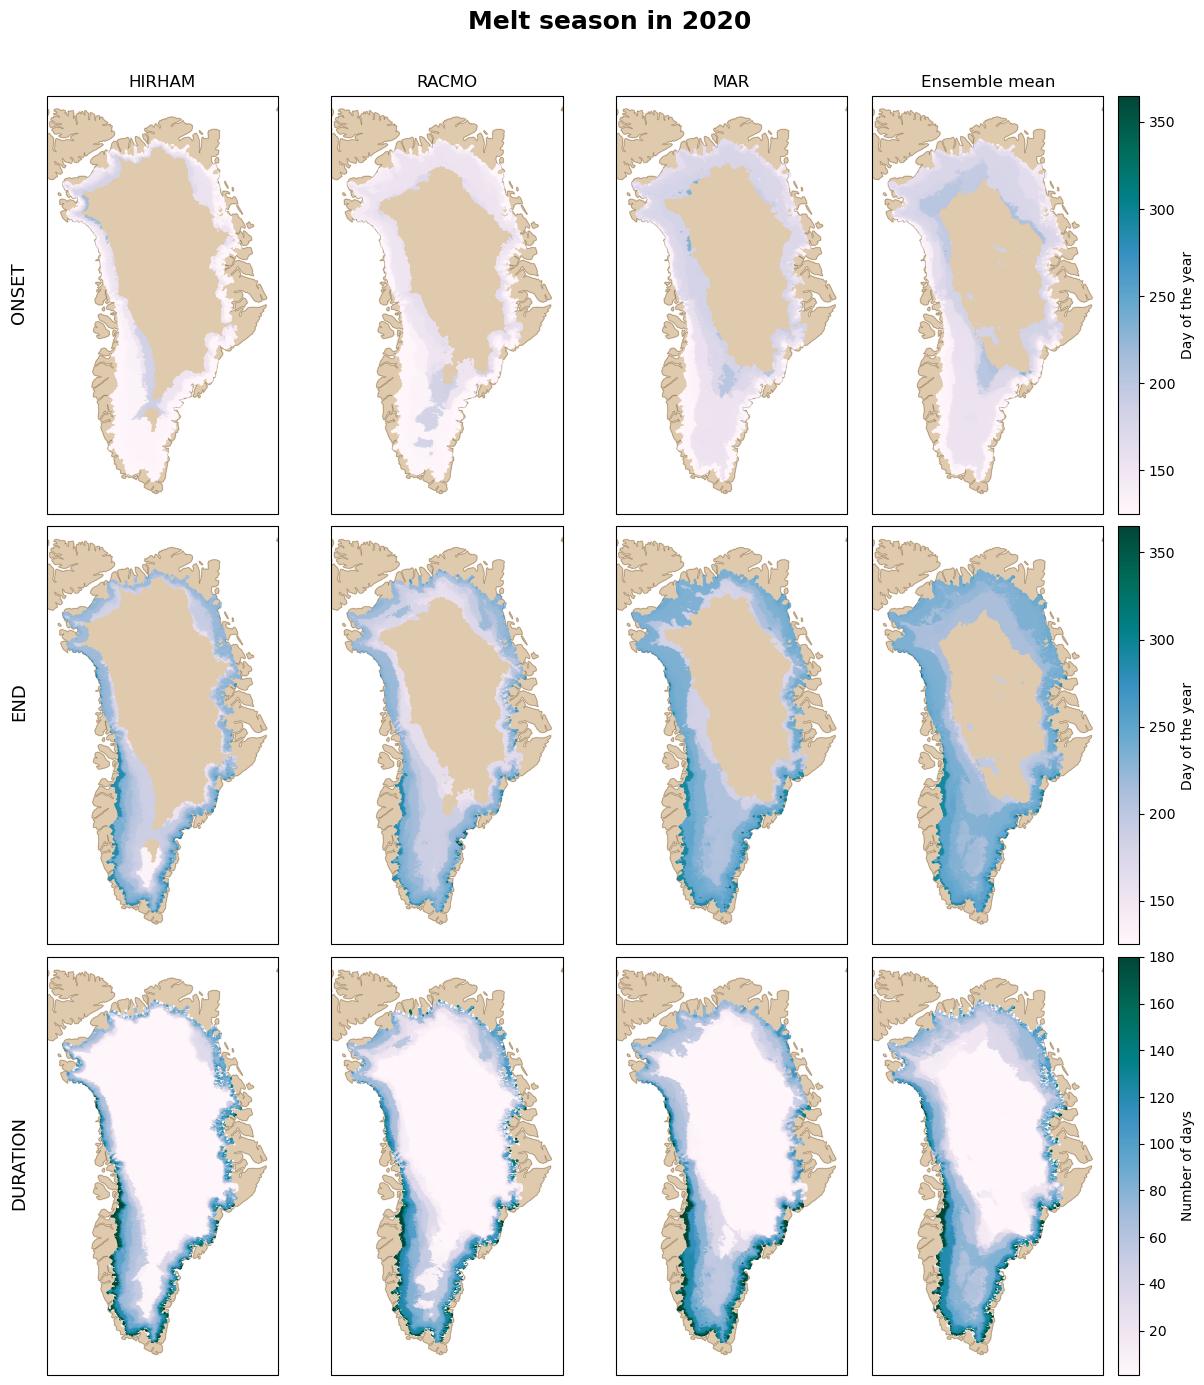

In [7]:
len_threshold = 3 # Number of consecutive days with active melt in order to classify the melt season. 
magn_threshold = [1, 10000] # 10000 indicates no upper threshold for melt intensity. 

# Compute start and end of melt season for each RCM;  
start_racmo, end_racmo = melt_season(racmo.reshape((racmo.shape[0], -1)).T, magn_threshold, len_threshold)
start_hirham, end_hirham = melt_season(hirham.reshape((hirham.shape[0], -1)).T, magn_threshold, len_threshold)
start_mar, end_mar = melt_season(mar.reshape((mar.shape[0], -1)).T, magn_threshold, len_threshold)
start_ens, end_ens = melt_season(ens_mean.reshape((ens_mean.shape[0], -1)).T, magn_threshold, len_threshold)

# Compute the duration of the melt season: 
duration_hirham = end_hirham - start_hirham
duration_racmo = end_racmo - start_racmo
duration_mar = end_mar - start_mar
duration_ens = end_ens - start_ens

# Set pixels without melt days on the icesheet to 0 duration. 
duration_hirham[(duration_hirham.astype(str)==str(np.nan)) & (ascat_mask.astype(str) != str(np.nan)) ] = 0
duration_racmo[(duration_racmo.astype(str)==str(np.nan)) & (ascat_mask.astype(str) != str(np.nan)) ] = 0
duration_mar[(duration_mar.astype(str)==str(np.nan)) & (ascat_mask.astype(str) != str(np.nan)) ] = 0
duration_ens[(duration_ens.astype(str)==str(np.nan)) & (ascat_mask.astype(str) != str(np.nan)) ] = 0

 
# Plot results: 
fig, axs = plt.subplots(3, 4, figsize = (12,14), subplot_kw={'projection': plot_proj})
fig.suptitle(f'Melt season in {year}\n\n',fontsize = 18, fontweight = 'bold')
# HIRHAM plots : 
plot_greenland(start_hirham, axs[0,0],  mask = ascat_mask, vmin = 150, vmax = 365)
plot_greenland(end_hirham, axs[1,0],  mask = ascat_mask, vmin = 150, vmax = 365)
plot_greenland(duration_hirham, axs[2,0], mask = ascat_mask, vmin = 1, vmax = 180)
axs[0,0].set_title('HIRHAM')

# RACMO plots : 
plot_greenland(start_racmo, axs[0,1],   mask = ascat_mask, vmin = 150, vmax = 365)
plot_greenland(end_racmo, axs[1,1],  mask = ascat_mask, vmin = 150, vmax = 365)
plot_greenland(duration_racmo, axs[2,1],  mask = ascat_mask, vmin = 1, vmax = 180)
axs[0,1].set_title('RACMO')

# MAR plots 
plot_greenland(start_mar, axs[0,2],  mask = ascat_mask,  vmin = 125, vmax = 365)
plot_greenland(end_mar, axs[1,2],  mask = ascat_mask,  vmin = 125, vmax = 365) 
plot_greenland(duration_mar, axs[2,2],  mask = ascat_mask,  vmin = 1, vmax = 180)
axs[0,2].set_title('MAR')

# Ensemble mean plots 
plot_greenland(start_ens, axs[0,3],   mask = ascat_mask, cbar = True,  
               cbar_label = 'Day of the year', 
               vmin = 125, vmax = 365)
plot_greenland(end_ens, axs[1,3], mask = ascat_mask, cbar = True,  
               cbar_label = f'Day of the year', 
               vmin = 125, vmax = 365)
plot_greenland(duration_ens, axs[2,3], mask = ascat_mask, cbar = True,  
               cbar_label = f'Number of days', 
               vmin = 1, vmax = 180)
axs[0,3].set_title('Ensemble mean')
# 
plt.figtext(-0, 0.8, 'ONSET', ha='left', va='top', rotation = 'vertical', fontsize =13)
plt.figtext(-0, 0.5, 'END', ha='left', va='top', rotation = 'vertical', fontsize =13)
plt.figtext(-0, 0.19, 'DURATION', ha='left', va='top', rotation = 'vertical', fontsize =13)
fig.tight_layout(pad = 0.5)
plt.show()


# Load ASCAT and compute the melt season 

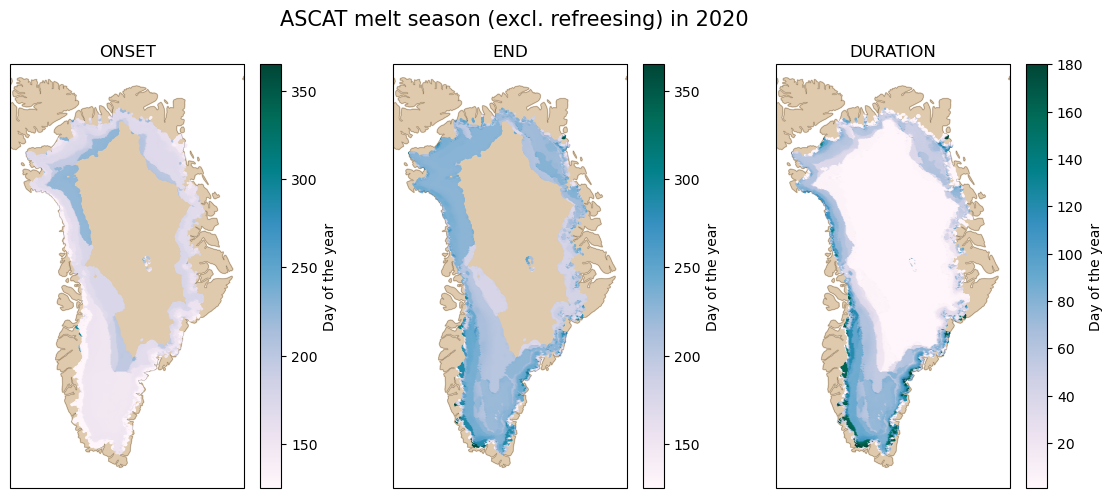

In [8]:
# Import one year of ascat meltmaps. 
ascat = []
# define the daterange for that year: 
dates_ascat = pd.date_range(datetime.date(year,1, 1), periods = racmo.shape[0])
for date in dates_ascat: 
    date_str = date.strftime('%Y-%m-%d')
    # Find file: 
    file = glob.glob(home_dir + f'/ASCAT/{year}/meltmap_{date_str}.tif')
    # if there is no file then make it completely no melt. This can only be done since the meltmaps already have 
    # filled datagaps and therefore only a few winter days are missing (except for 2019 where summer data is missing)
    if len(file) == 0: 
        tif = ascat_mask
        tif[tif == 1] = 0
    # if there is a file then open it: 
    else: 
        tif = read_tif(file[0])
        tif[tif >= 5] = np.nan # Set bedrock and ocean to nan. 
    
    ascat.append(tif) # Append to data array    
    
ascat = np.array(ascat)  

# Save as pickle:
#with open(f'/home/annpug/Desktop/annpug/ascat_{year}.pkl','wb') as f:
#    pickle.dump(ascat, f)

# Melt season begins when the next three days also have melt and ends with the last 3 days of refree: 
ascat_threshold = 2
# Melt is defined as either class 1 or class 2; (eg. excluding the refreezing class): 
onset_ascat, end_ascat = melt_season(ascat.reshape((ascat.shape[0], -1)).T, [0.9, 2.1], ascat_threshold)
# Compute duration of melt season: 
duration_ascat = end_ascat - onset_ascat
# Set pixels without a melt season but inside the icemask to zero:
duration_ascat[(duration_ascat.astype(str)==str(np.nan)) & (ascat_mask.astype(str) != str(np.nan)) ] = 0

# Plot results 
fig, axs = plt.subplots(1, 3, figsize = (14,5.5), subplot_kw={'projection': plot_proj})
fig.suptitle(f'ASCAT melt season (excl. refreesing) in {year}\n', fontsize = 15)
plot_greenland(onset_ascat, axs[0], vmin = 125, vmax = 365, cbar = True, cbar_label = f'Day of the year' )
axs[0].set_title('ONSET')
plot_greenland(end_ascat , axs[1], vmin = 125, vmax = 365, cbar = True, cbar_label = f'Day of the year')
axs[1].set_title('END')
plot_greenland(duration_ascat, axs[2], vmin = 1, vmax = 180, cbar = True, cbar_label = f'Day of the year')
axs[2].set_title('DURATION')
plt.show()

# Maps with differences bewteen melt season in ASCAT and RCMs

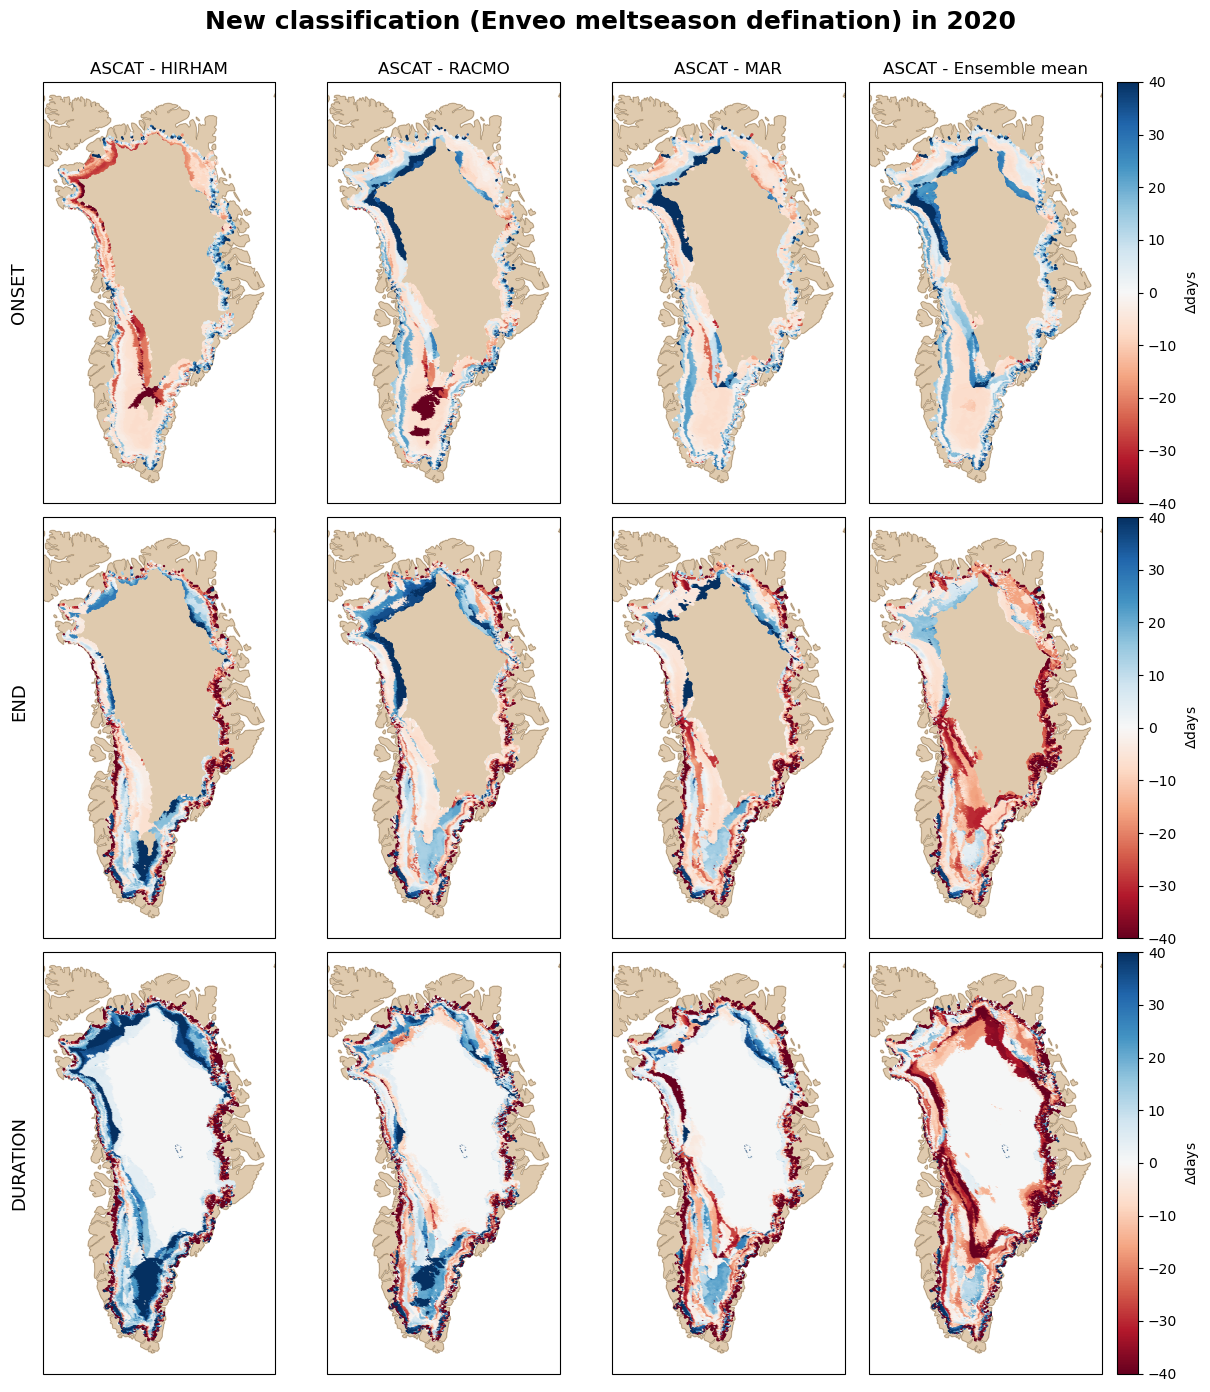

In [9]:
# Plot settings: 
cmap = 'RdBu'
minlim = -40
maxlim = 40

# hirham 
onset_dif_hirham = onset_ascat- start_hirham
end_dif_hirham = end_ascat - end_hirham
duration_dif_hirham = duration_ascat - duration_hirham
# racmo 
onset_dif_racmo = onset_ascat - start_racmo
end_dif_racmo = end_ascat - end_racmo
duration_dif_racmo = duration_ascat - duration_racmo 
# mar
onset_dif_mar = onset_ascat - start_mar
end_dif_mar = end_ascat - end_mar
duration_dif_mar = duration_ascat- duration_mar 
# ensemble mean 
onset_dif_ens = onset_ascat - start_ens
end_dif_ens = end_ascat - end_ens
duration_dif_ens = duration_ascat - duration_ens


# Plot of results 
fig, axs = plt.subplots(3, 4, figsize = (12,14), subplot_kw={'projection': plot_proj})
fig.suptitle(f'New classification (Enveo meltseason defination) in {year}\n\n', fontsize = 18, fontweight = 'bold')
# Hirham 
plot_greenland(onset_dif_hirham, axs[0,0], vmin = minlim, vmax = maxlim, cmap = cmap)
plot_greenland(end_dif_hirham, axs[1,0], vmin = minlim, vmax = maxlim, cmap = cmap)
plot_greenland(duration_dif_hirham, axs[2,0], vmin = minlim, vmax = maxlim, cmap = cmap)
axs[0,0].set_title('ASCAT - HIRHAM')
axs[0,1].set_ylabel('ONSET')
axs[1,1].set_ylabel('END')
axs[2,1].set_ylabel('DURATION')
# racmo 
plot_greenland(onset_dif_racmo, axs[0,1],  vmin =minlim, vmax = maxlim, cmap = cmap)
plot_greenland(end_dif_racmo, axs[1,1],  vmin = minlim, vmax = maxlim, cmap = cmap)
plot_greenland(duration_dif_racmo, axs[2,1],  vmin = minlim, vmax = maxlim, cmap = cmap)
axs[0,1].set_title('ASCAT - RACMO')
# mar 
plot_greenland(onset_dif_mar, axs[0,2],  vmin = minlim, vmax = maxlim, cmap = cmap)
plot_greenland(end_dif_mar, axs[1,2],   vmin = minlim, vmax = maxlim, cmap = cmap)
plot_greenland(duration_dif_mar, axs[2,2],  vmin = minlim, vmax = maxlim, cmap = cmap)
axs[0,2].set_title('ASCAT - MAR')
# ensembel mean 
plot_greenland(onset_dif_ens, axs[0,3],  cbar = True,  
               cbar_label = r'$\Delta$days', 
               vmin = minlim, vmax = maxlim, cmap = cmap)
plot_greenland(end_dif_ens, axs[1,3],  cbar = True,  
               cbar_label = r'$\Delta$days', 
               vmin = minlim, vmax = maxlim, cmap = cmap)
plot_greenland(duration_dif_ens, axs[2,3],  cbar = True,  
               cbar_label = r'$\Delta$days', 
               vmin = minlim, vmax = maxlim, cmap = cmap)
axs[0,3].set_title('ASCAT - Ensemble mean')
plt.figtext(-0, 0.8, 'ONSET', ha='left', va='top', rotation = 'vertical', fontsize =13)
plt.figtext(-0, 0.5, 'END', ha='left', va='top', rotation = 'vertical', fontsize =13)
plt.figtext(-0, 0.19, 'DURATION', ha='left', va='top', rotation = 'vertical', fontsize =13)
fig.tight_layout(pad = 0)
plt.show()

# Compare number of melt days 

In [49]:
# Compute the number of days where melt is over the specified threshold:
threshold = 5
meltdays_racmo = number_of_meltdays(racmo,threshold)
meltdays_hirham = number_of_meltdays(hirham,threshold)
meltdays_mar = number_of_meltdays(mar,threshold)
meltdays_carra = number_of_meltdays(carra,threshold)
meltdays_ens = number_of_meltdays(ens_mean,threshold)

# Compute number of melt days for ASCAT 
melt_ascat = np.zeros(ascat.shape)
melt_ascat[(ascat >= 1) & (ascat <= 2)] = 1
meltdays_ascat = np.sum(melt_ascat, axis = 0) # Sum to get the number of days in each pixel
meltdays_ascat[meltdays_ascat == 0] = np.nan

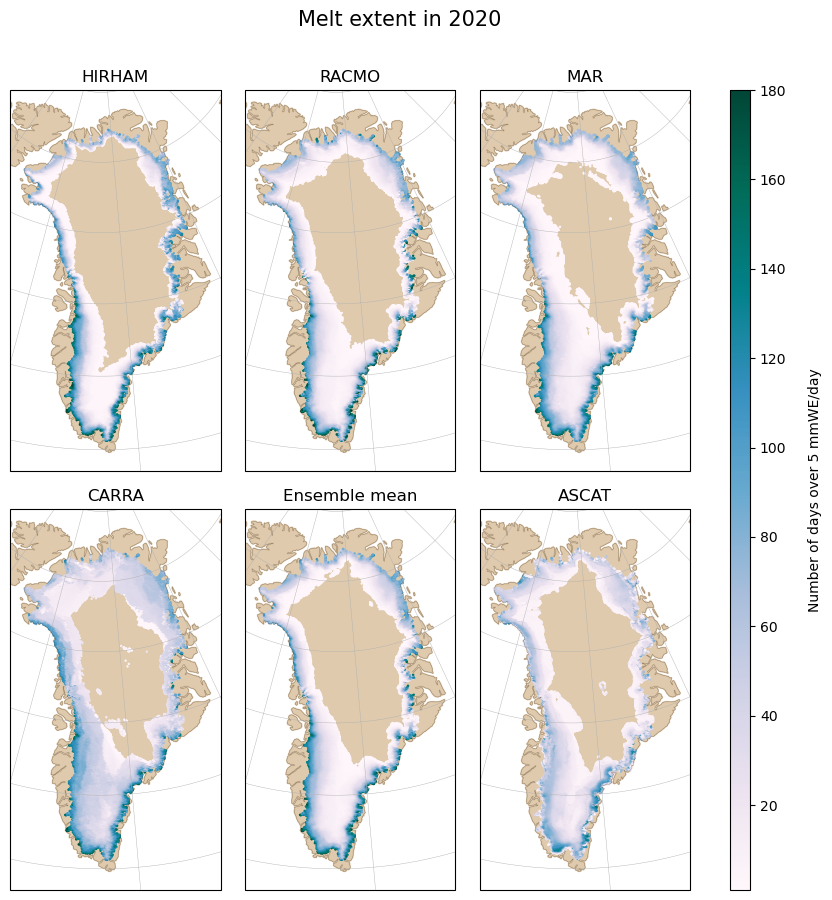

In [59]:
# Plot results: 
fig, axs = plt.subplots(2, 3, figsize = (10,10), subplot_kw={'projection': plot_proj})
plot_greenland(meltdays_hirham, axs[0,0], mask = ascat_mask, vmin = 1, vmax = 180)
axs[0,0].set_title('HIRHAM')
axs[0,0].gridlines(linewidth=0.3)
plot_greenland(meltdays_racmo, axs[0,1], mask = ascat_mask, vmin = 1, vmax = 180)
axs[0,1].set_title('RACMO')
axs[0,1].gridlines(linewidth=0.3)
plot_greenland(meltdays_mar, axs[0,2], mask = ascat_mask,  vmin = 1, vmax = 180)
axs[0,2].set_title('MAR')
axs[0,2].gridlines(linewidth=0.3)
plot_greenland(meltdays_carra, axs[1,0], mask = ascat_mask, vmin = 1, vmax = 180)
axs[1,0].set_title('CARRA')
axs[1,0].gridlines(linewidth=0.3)
plot_greenland(meltdays_ens, axs[1,1], mask = ascat_mask, vmin = 1, vmax = 180)
axs[1,1].set_title('Ensemble mean')
axs[1,1].gridlines(linewidth=0.3)
im = plot_greenland(meltdays_ascat, axs[1,2], mask = ascat_mask,  
               #cbar_label = f'Number of days over {threshold} mmWE/day', 
               vmin = 1, vmax = 180)
axs[1,2].set_title('ASCAT')
axs[1,2].gridlines(linewidth=0.3)
fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.8,
                    wspace=0.02, hspace=0.1)
cb_ax = fig.add_axes([0.83, 0.1, 0.02, 0.8])
cbar = fig.colorbar(im, cax=cb_ax, label = f'\nNumber of days over {threshold} mmWE/day')
fig.suptitle(f'Melt extent in {year}\n\n', fontsize = 15)
plt.show()

## a) Melt days ratio 

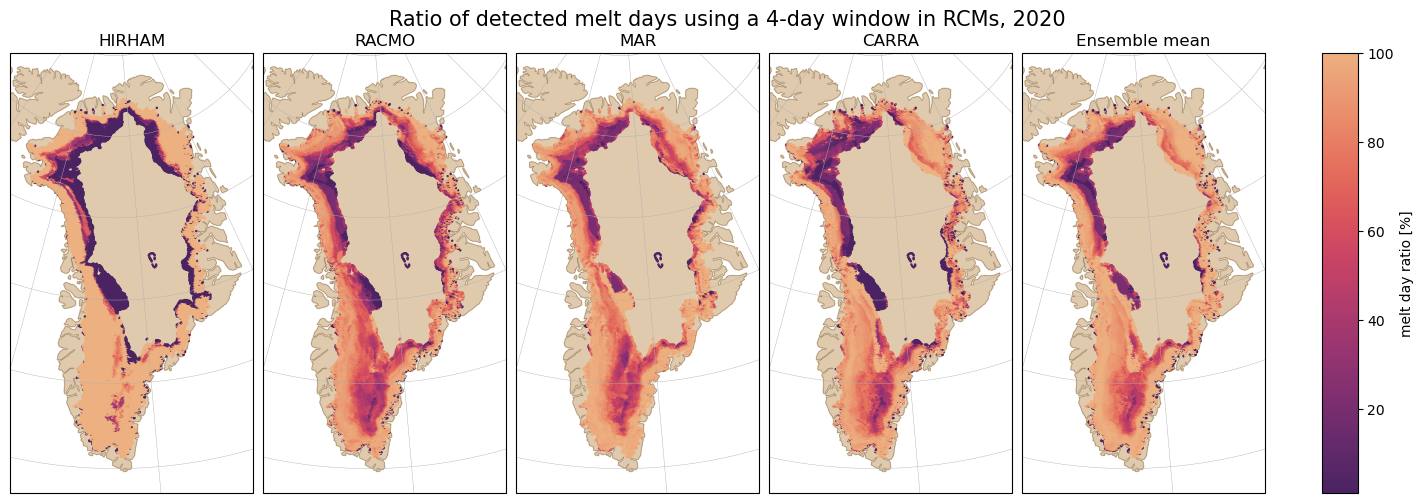

In [73]:
cmap = sns.color_palette("flare_r", as_cmap=True)
window = 4


match_hirham = window_comparison(melt_ascat, hirham, 1, window)
match_racmo = window_comparison(melt_ascat, racmo, 1,  window)
match_mar = window_comparison(melt_ascat, mar, 1, window)
match_carra = window_comparison(melt_ascat, carra, 1, window)
match_ens = window_comparison(melt_ascat, ens_mean, 1, window)
                               
# Plot
fig, axs = plt.subplots(1, 5, figsize = (18,5.5), subplot_kw={'projection': cartopy.crs.NorthPolarStereo(central_longitude=-45)})
fig.suptitle(f'Ratio of detected melt days using a {window}-day window in RCMs, {year}\n\n', fontsize = 15)
plot_greenland(match_hirham, axs[0],  vmin = 0, vmax = 30,  cmap=cmap)
axs[0].set_title('HIRHAM')
axs[0].gridlines(linewidth=0.3)
plot_greenland(match_racmo, axs[1], vmin = 0, vmax = 100, cmap=cmap)
axs[1].set_title('RACMO')
axs[1].gridlines(linewidth=0.3)
plot_greenland(match_mar, axs[2],   vmin = 0, vmax = 100, cmap=cmap)
axs[2].set_title('MAR')
axs[2].gridlines(linewidth=0.3)
plot_greenland(match_carra, axs[3],   vmin = 0, vmax = 100, cmap=cmap)
axs[3].set_title('CARRA')
axs[3].gridlines(linewidth=0.3)
im = plot_greenland(match_ens, axs[4],  #cbar = True,  
               #cbar_label = f'melt days ratio [%]', 
               vmin = 1, vmax = 100, cmap=cmap)
axs[4].set_title('Ensemble mean')
axs[4].gridlines(linewidth=0.3)
fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.8,
                    wspace=0.02, hspace=0.2)
cb_ax = fig.add_axes([0.83, 0.1, 0.02, 0.8])
cbar = fig.colorbar(im, cax=cb_ax, label = f'melt day ratio [%]')
plt.show()

## b) Refreezing ratio

/tmp/ipykernel_12779/2095330518.py:186: RuntimeWarning: invalid value encountered in divide
  return np.divide(sum_match,sum_ascat)*100 # Computed ratio.


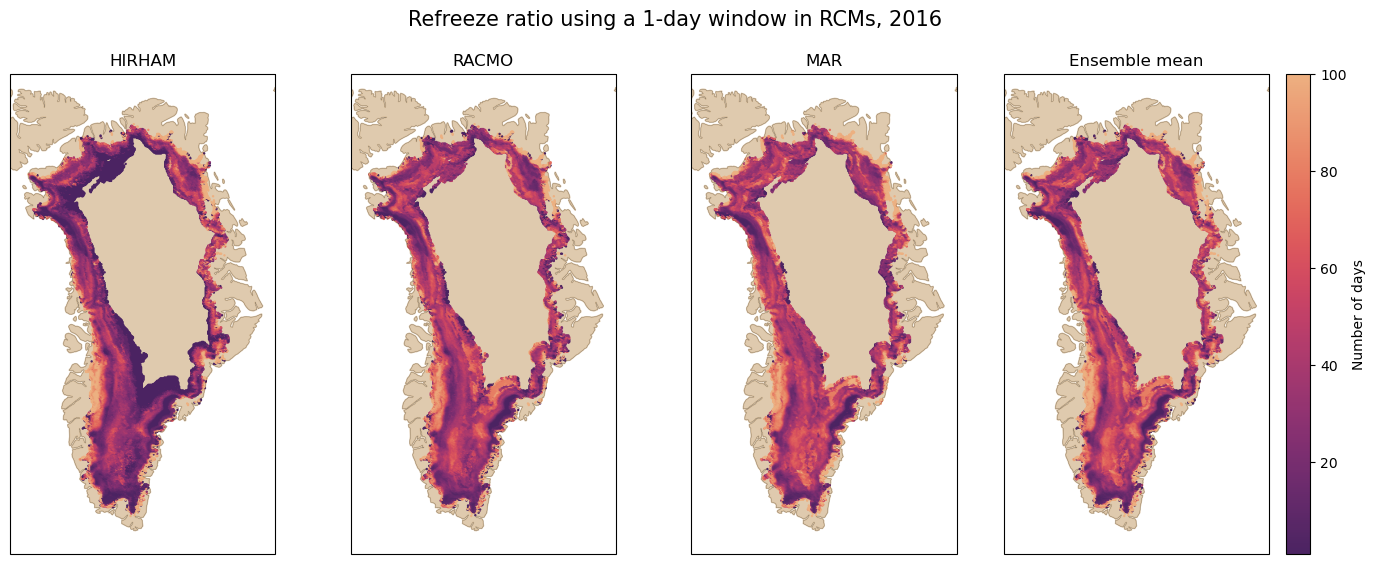

In [45]:
window_refreeze = 1
refreeze_ascat = np.zeros(ascat.shape)
refreeze_ascat[ascat == 3] = 1

match_refreeze_hirham = window_comparion(refreeze_ascat, hirham, 1, window_refreeze)
match_refreeze_racmo = window_comparion(refreeze_ascat, racmo, 1,  window_refreeze)
match_refreeze_mar = window_comparion(refreeze_ascat, mar, 1, window_refreeze)
match_refreeze_ens = window_comparion(refreeze_ascat, ens_mean, 1, window_refreeze)

# Plot
fig, axs = plt.subplots(1, 4, figsize = (14,5.5), subplot_kw={'projection': cartopy.crs.NorthPolarStereo(central_longitude=-45)})
fig.suptitle(f'Refreeze ratio using a {window_refreeze}-day window in RCMs, {year}\n\n', fontsize = 15)
plot_greenland(match_refreeze_hirham, axs[0],  vmin = 0, vmax = 100,  cmap=cmap)
axs[0].set_title('HIRHAM')
plot_greenland(match_refreeze_racmo, axs[1],  vmin = 0, vmax = 100, cmap=cmap)
axs[1].set_title('RACMO')
plot_greenland(match_refreeze_mar, axs[2],    vmin = 0, vmax = 100, cmap=cmap)
axs[2].set_title('MAR')
plot_greenland(match_refreeze_ens, axs[3],  cbar = True,  
               cbar_label = f'Number of days', 
               vmin = 1, vmax = 100, cmap=cmap)
axs[3].set_title('Ensemble mean')
fig.tight_layout(pad = -0.4)
plt.show()

## c) Differentiation of intermidiate aend end refreeze

In [149]:
end_refreeze = np.argwhere((refreeze_ascat[:-1,:,:] - refreeze_ascat[1:,:,:]) == 1)
sorted_end_indices = np.lexsort((end_refreeze[:, 2], end_refreeze [:, 1]))
end_refreeze = end_refreeze[sorted_end_indices]

start_refreeze = np.argwhere((refreeze_ascat[:-1,:,:] - refreeze_ascat[1:,:,:]) == -1)
sorted_start_indices = np.lexsort((start_refreeze[:, 2],start_refreeze [:, 1]))
start_refreeze = start_refreeze[sorted_start_indices]


intermidiate_refreeze_ascat = np.zeros(ascat.shape)
end_refreeze_ascat = np.zeros(ascat.shape) 

for i in range(len(end_refreeze)):
    ascat_after_refreeze = ascat[end_refreeze[i,0]+1:, end_refreeze[i,1], end_refreeze[i,2]]
    
    # If the melt is detected after refreezing; 
    if sum(ascat_after_refreeze) > 0: 
        intermidiate_refreeze_ascat[start_refreeze[i,0]+1:end_refreeze[i,0]+1,end_refreeze[i, 1], end_refreeze[i,2]] = 1
    # No melt class after refreezing: 
    if sum(ascat_after_refreeze) == 0: 
        end_refreeze_ascat[start_refreeze[i,0]+1:end_refreeze[i,0]+1,end_refreeze[i, 1], end_refreeze[i,2]] = 1


/tmp/ipykernel_15549/4273480225.py:104: RuntimeWarning: invalid value encountered in divide
  return np.divide(sum_melt_match,sum_melt_ascat)*100


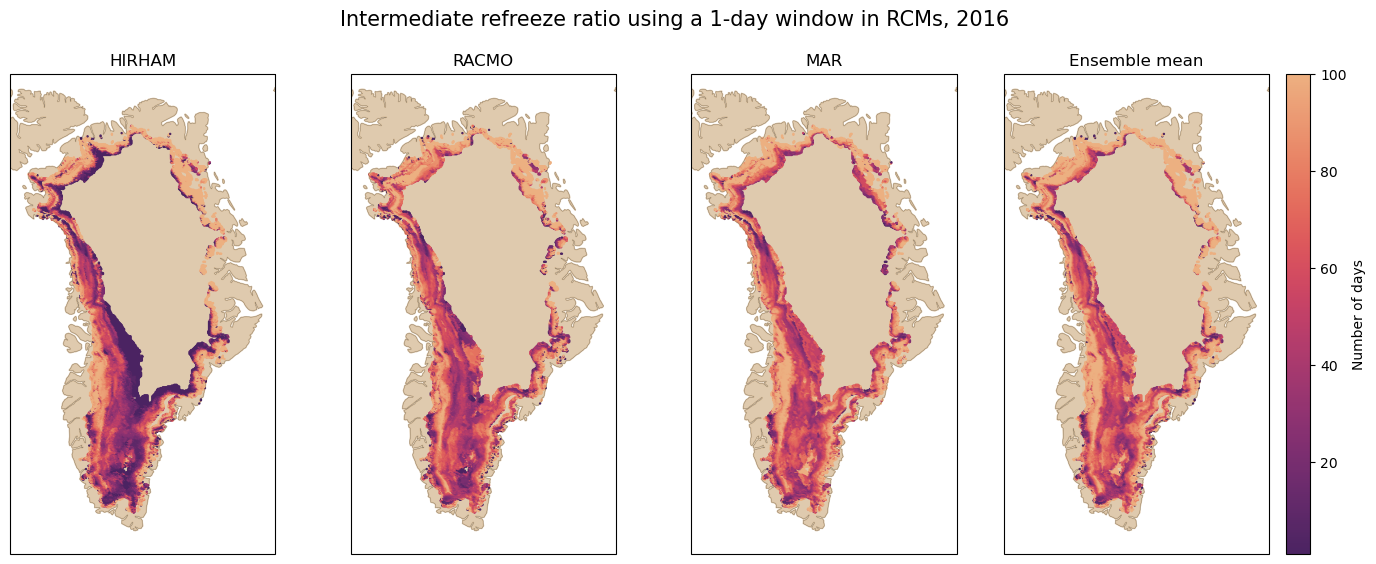

In [150]:
match_inter_refreeze_hirham = window_comparion(intermidiate_refreeze_ascat, hirham, 1, window_refreeze)
match_inter_refreeze_racmo = window_comparion(intermidiate_refreeze_ascat, racmo, 1,  window_refreeze)
match_inter_refreeze_mar = window_comparion(intermidiate_refreeze_ascat, mar, 1, window_refreeze)
match_inter_refreeze_ens = window_comparion(intermidiate_refreeze_ascat, ens_mean, 1, window_refreeze)    

# Plot
fig, axs = plt.subplots(1, 4, figsize = (14,5.5), subplot_kw={'projection': cartopy.crs.NorthPolarStereo(central_longitude=-45)})
fig.suptitle(f'Intermediate refreeze ratio using a {window_refreeze}-day window in RCMs, {year}\n\n', fontsize = 15)
plot_greenland(match_inter_refreeze_hirham, axs[0], crs_epsg, vmin = 0, vmax = 100,  cmap=cmap)
axs[0].set_title('HIRHAM')
plot_greenland(match_inter_refreeze_racmo, axs[1], crs_epsg,  vmin = 0, vmax = 100, cmap=cmap)
axs[1].set_title('RACMO')
plot_greenland(match_inter_refreeze_mar, axs[2], crs_epsg,    vmin = 0, vmax = 100, cmap=cmap)
axs[2].set_title('MAR')
plot_greenland(match_inter_refreeze_ens, axs[3], crs_epsg,  cbar = True,  
               cbar_label = f'Number of days', 
               vmin = 1, vmax = 100, cmap=cmap)
axs[3].set_title('Ensemble mean')
fig.tight_layout(pad = -0.4)
plt.show()

/tmp/ipykernel_15549/4273480225.py:104: RuntimeWarning: invalid value encountered in divide
  return np.divide(sum_melt_match,sum_melt_ascat)*100


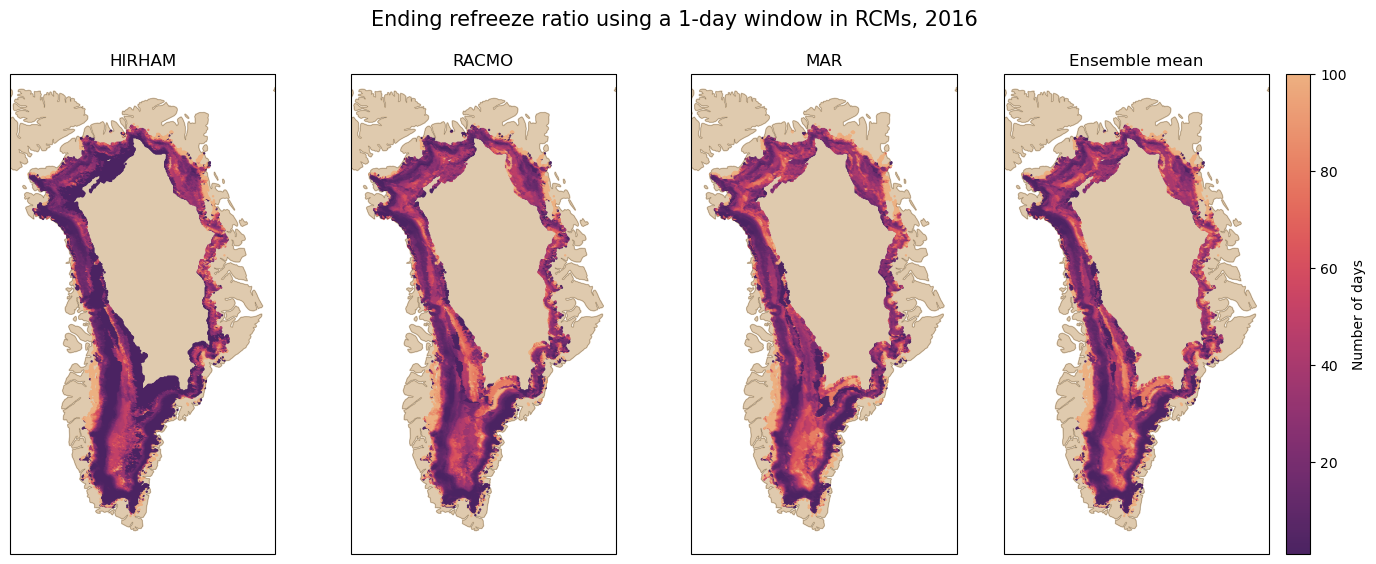

In [151]:
match_end_refreeze_hirham = window_comparion(end_refreeze_ascat, hirham, 1, window_refreeze)
match_end_refreeze_racmo = window_comparion(end_refreeze_ascat, racmo, 1,  window_refreeze)
match_end_refreeze_mar = window_comparion(end_refreeze_ascat, mar, 1, window_refreeze)
match_end_refreeze_ens = window_comparion(end_refreeze_ascat, ens_mean, 1, window_refreeze)    

# Plot
fig, axs = plt.subplots(1, 4, figsize = (14,5.5), subplot_kw={'projection': cartopy.crs.NorthPolarStereo(central_longitude=-45)})
fig.suptitle(f'Ending refreeze ratio using a {window_refreeze}-day window in RCMs, {year}\n\n', fontsize = 15)
plot_greenland(match_end_refreeze_hirham, axs[0], crs_epsg, vmin = 0, vmax = 100,  cmap=cmap)
axs[0].set_title('HIRHAM')
plot_greenland(match_end_refreeze_racmo, axs[1], crs_epsg,  vmin = 0, vmax = 100, cmap=cmap)
axs[1].set_title('RACMO')
plot_greenland(match_end_refreeze_mar, axs[2], crs_epsg,    vmin = 0, vmax = 100, cmap=cmap)
axs[2].set_title('MAR')
plot_greenland(match_end_refreeze_ens, axs[3], crs_epsg,  cbar = True,  
               cbar_label = f'Number of days', 
               vmin = 1, vmax = 100, cmap=cmap)
axs[3].set_title('Ensemble mean')
fig.tight_layout(pad = -0.4)
plt.show()

# Save selected results as geotif-files

In [153]:
# Get grid and geometry information from a ASCAT file (since everthing is on the same grid)
ds = gdal.Open('/mnt/h1/projects/4DGreenland/meltmap_v02/ASCAT/meltmap_v02_2016-01-02.tif')

# Melt season maps 
model = 'ens'
write_geotiff(f"/home/annpug/Desktop/annpug/difference_maps/ASCAT_{model}_end_{year}.tif", end_dif_ens, ds)
write_geotiff(f"/home/annpug/Desktop/annpug/difference_maps/ASCAT_{model}_onset_{year}.tif", onset_dif_ens, ds)
write_geotiff(f"/home/annpug/Desktop/annpug/difference_maps/ASCAT_{model}_duration_{year}.tif", duration_dif_ens, ds)

# Melt and refreezing ratios: 
write_geotiff(f"/home/annpug/Desktop/annpug/difference_maps/ASCAT_hirham_melt_days_{year}.tif",  match_hirham.astype('float32'), ds)
write_geotiff(f"/home/annpug/Desktop/annpug/difference_maps/ASCAT_racmo_melt_days_{year}.tif", match_racmo.astype('float32'), ds)
write_geotiff(f"/home/annpug/Desktop/annpug/difference_maps/ASCAT_mar_melt_days_{year}.tif", match_mar.astype('float32'), ds)
write_geotiff(f"/home/annpug/Desktop/annpug/difference_maps/ASCAT_ens_melt_days_{year}.tif", match_ens.astype('float32'), ds)

write_geotiff(f"/home/annpug/Desktop/annpug/difference_maps/ASCAT_hirham_end_refreezing_days_{year}.tif", match_end_refreeze_hirham.astype('float32'), ds)
write_geotiff(f"/home/annpug/Desktop/annpug/difference_maps/ASCAT_racmo_end_refreezing_days_{year}.tif", match_end_refreeze_racmo.astype('float32'), ds)
write_geotiff(f"/home/annpug/Desktop/annpug/difference_maps/ASCAT_mar_end_refreezing_days_{year}.tif", match_end_refreeze_mar.astype('float32'), ds)
write_geotiff(f"/home/annpug/Desktop/annpug/difference_maps/ASCAT_ens_end_refreezing_days_{year}.tif", match_end_refreeze_ens.astype('float32'), ds)
